# Exercise 1: Image Compression

**Deadline: 23 December 2022, 11:59 PM**            

**Covered Topics: Lecture 1-3**

You are organizing a tic-tac-toe championship with your friends, where all the games will be played on a gaming console, i.e. on a digital board. Due to the wide interest in the championship, you want to share the live games on internet. Thus, you plan to record the games using an external camera, and transmit it. Your friend from mechanical engineering has already agreed to help you with the camera setup. Unfortunately, being a poor student, you can only afford a cheap camera which provides you noisy images. To make the matter worse, your internet connection is poor and hence you cannot transmit the full images directly due to large file size. Thankfully, you are currently taking a computer vision course :) Thus you decide to use your newly acquired knowledge to design a software which can i) compress the images obtained from the camera for efficient transmission, and ii) reconstruct the compressed images on the client side to generate a high quality, noise free, output. An overview of the entire pipeline is shown in Figure.

![](https://drive.google.com/uc?export=view&id=1uTn7XN-hU8On_Ez-OKLgWCxDDg971A4k "Title")

**Details about the setup**
* The camera is placed exactly about the console screen. Both the console, and the camera are rigidly placed, i.e. they do not move. Furthermore, the screen is always fully visible in the camera and we do not have any other object, e.g. hand entering the camera view.
* The actual game image $x$ (the one displayed on the console screen) is a discrete RGB image of size 96 x 96. Each pixel in the image is an integer which can take values between [0, 255]. In fact, the pixels at each location in the image can take only one of 4 values, white for the background region, black for the grid lines, red for the X sign, and green for the O sign.
* The camera provides you an RGB image $\hat{x}$ of size 96 x 96 which is corrupted by noise. Each pixel in the image is a 32-bit floating-point number which can take any continuous value between [0.0, 255.0].  Note that due to the presence of noise, the pixels in the camera image can take any continuous value, even though pixels in the original image only have discrete integral values.


In order to design your compression algorithm, you have access to a dataset $\mathcal{D}_{train} = \{\hat{x}_i\}_{i=1}^{100}$ containing 100 noisy images captured using the exact same camera setup. You can use this dataset to learn codebook $\mathcal{C}$ which you use for compression. For instance, if you use Principal Component Analysis (PCA) approach for compression, the codebook $\mathcal{C}$ will contain the first $K$ principal components, as well as the mean image. Given a new image $\hat{x}_j$ from a game, and the learnt codebook $\mathcal{C}$, your compression algorithm should output a compressed representation $z_j = \texttt{Compress}(\hat{x}_j, \mathcal{C})$, which is smaller in size compared to $\hat{x}_j$. Finally, you should also provide a reconstruction algorithm which can recover an estimate $x^{pred}_j = \texttt{Reconstruct}(z_j, \mathcal{C})$ of the **original** clean image $x_j$ given the compressed version $z_j$ and the codebook $\mathcal{C}$.

For debugging purposes, we also provde a validation dataset containing 50 noisy images, as well as the clean ground truth for each of these images.

**Evaluation Criteria**

Your method will be evaluated using three criterias, namey the size of the codebook, the compression ability and the reconstruction quality. For evaluation, you are provided with a test dataset $\mathcal{D}_{test} = \{\hat{x}_j\}_{j=1}^{50}$ containing 50 noisy images. Your method should output i) the compressed representations $z_j$ for each of the test images, ii) the codebook $\mathcal{C}$ employed for compression, and iii) the reconstructed version $x^{pred}_j$ for each of the test images. **Note** that both your codebook $\mathcal{C}$, as well as the compressed representations $z_j$ are **required** to be Numpy arrays. The codebook size, the mean compressed size, and the mean reconstruction error are then computed as follows,

$$ \text{CodebookSize} = \texttt{Size}(\mathcal{C})$$
$$ \text{MeanCompressedSize} = \frac{1}{50}\sum_{j=1}^{50} \texttt{Size}(z_j) $$
$$ \text{MeanReconError} = \frac{1}{100}\sum_{j=1}^{100} \|x^{pred}_j - x_j\|_2 $$

Here, $\|.\|_2$ denotes the $\mathcal{L}_2$ norm. That is, it computes the root mean squared error between the pixel values of predicted image and the ground truth image over the full image. The $\texttt{Size}$ function computes the size of the input NumPy arrays based on their shape and data types, in terms of bytes. For instances, if your codebook $\mathcal{C}$ is a Numpy array of datatype $\texttt{uint8}$ and shape $50 \times 50 \times 3$, then $\texttt{Size}(\mathcal{C}) = 50*50*3*1$. Please refer to the evaluation script included in this notebook (`evaluation.py`) for more details.

The final evaluation score is obtained as the weighted sum of each of these individual scores,

$$ \text{EvaluationScore} = \text{MeanReconError} + \frac{1}{10^6}\text{CodebookSize} + \frac{1}{10}\text{MeanCompressedSize} $$

**Passing requirement**

In order to pass the exercise, you need to obtain an EvaluationScore of **less than $35$** on the test set. The evaluation on the test set is done using an online evaluation server at https://codalab.lisn.upsaclay.fr/competitions/7754. Follow the steps in the rest of the notebook to generate the submission.

## Initialize the environment and load data
Import the necessary libraries. Note that you are **NOT** allowed to use any additional libraries

In [17]:
# These two lines ensure that we always import the latest version of a package, in case it has been modified.
%load_ext autoreload
%autoreload 2

%matplotlib inline
from matplotlib import pyplot as plt
import cv2
import os
import numpy as np
import random

from google.colab import drive
drive.mount('/content/drive')

import sys

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**TODO:** Set the path in Google drive where you uploaded the handout, e.g. My Drive/iacv/ex1

In [ ]:
iacv_path = '/MyDrive/iacv_exercises/ex1_compression'
env_path = f'/content/drive/{iacv_path}'
# Add the handout folder to python paths
if env_path not in sys.path:
    sys.path.append(env_path)

# Import evaluation package
import evaluation

Helper functions to load and display images. You do not need to modify these functions.

In [ ]:
def load_image(im_path):
    im = cv2.imread(im_path)

    # OpenCV loads images in BGR format, that is first channel in the image is blue, second is green, and third is red.
    # matplotlib (which we will use to display images) on the image hand expects images in RGB format. Hence we perform a color conversion
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    return im

def show_image(im, title=None):
    plt.imshow(im)
    plt.title(title)
    plt.show()

def show_images(ims):
    fig, ax = plt.subplots(1,len(ims))

    for id in range(len(ims)):
        ax[id].imshow(ims[id])
    plt.imshow(im)
    plt.show()

Load the training, validation, and test images in a python list. This may take some time (a few minutes).

In [ ]:
print("Loading train images")
train_images = [load_image(f'{env_path}/train/{i:03d}.png') for i in range(100)]

print("Loading test images")
test_images = [load_image(f'{env_path}/test/{i:03d}.png') for i in range(50)]

print("Loading val images")
val_images = [load_image(f'{env_path}/val/{i:03d}.png') for i in range(50)]

print("Loading val ground truths")
val_gt = [load_image(f'{env_path}/val_gt/{i:03d}.png') for i in range(50)]

Loading train images
Loading test images
Loading val images
Loading val ground truths


Visualize a few validation images, along with ground truth to get an idea of how the images look. You can run this cell multiple times to visualize different images.

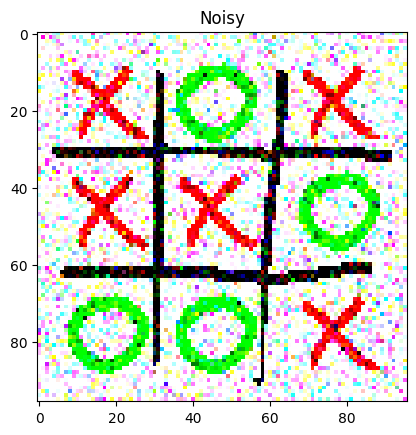

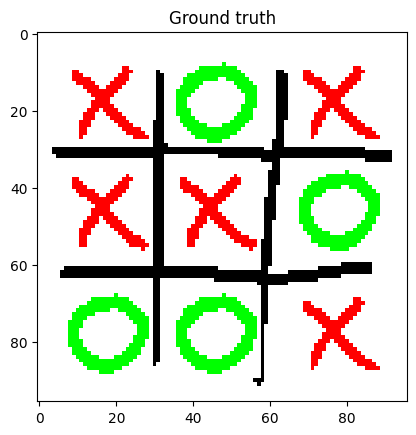

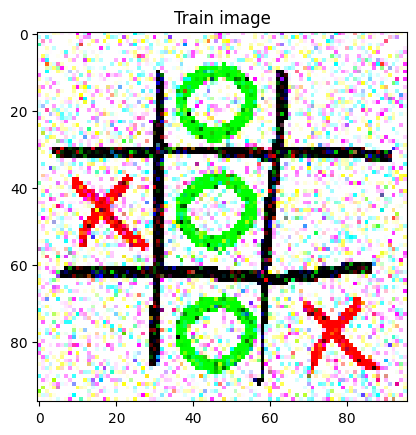

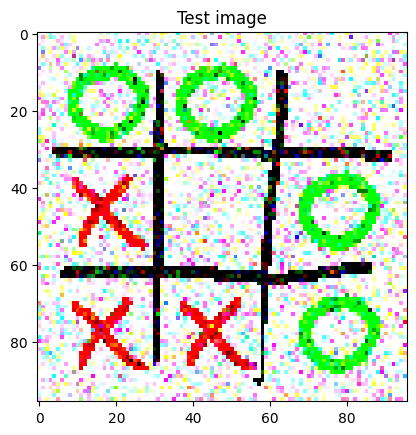

In [ ]:
idx = random.sample(list(range(50)), 1)[0]
show_image(val_images[idx], 'Noisy')
show_image(val_gt[idx], 'Ground truth')
show_image(train_images[idx], 'Train image')
show_image(test_images[idx], 'Test image')

## Implement your solution

**TODO:** You are provided with a simple implementation of the `ImageCompressor` and `ImageReconstructor` classes (image_compressor.py). The `ImageCompressor` class is used to learn the codebook, and obtain compressed representation of input images, while the `ImageReconstructor` class decodes the compressed representation to generate the output image. Modify these classes to include your compression and reconstruction algorithms. **Note:** You are not allowed to use any external packages except NumPy in `image_compressor.py`. Otherwise your submission will crash on the Evaluation server.

**Important:** The next cells demonstrate how the two classes will be used. Have a look at them before implementing your approach.


## Test your solution on validation set

Test your algorithm on some validation images and visualize the output. First, we initialize the ImageCompressor object and learn the codebook.

**Important:** Don't forget to import the `image_compressor` every time you modify the `image_compressor.py` file, otherwise your latest changes won't be loaded.

In [ ]:
# Import the image_compressor class everytime you modify image_compressor.py file.
# Otherwise your changes won't be loaded
import image_compressor

# Initialize the compressor object and learn the codebook
compressor = image_compressor.ImageCompressor()
compressor.train(train_images)

# get the learnt codebook
codebook = compressor.get_codebook()

# Initialize the reconstructor (This will be done on the client side)
reconstructor = image_compressor.ImageReconstructor(codebook)

Next, try reconstructing a few validation images and visualize results. We also print the evaluation scores. You are encouraged to check the evaluation code provided at evaluation.py. However you shouldn't modify the evaluation script.

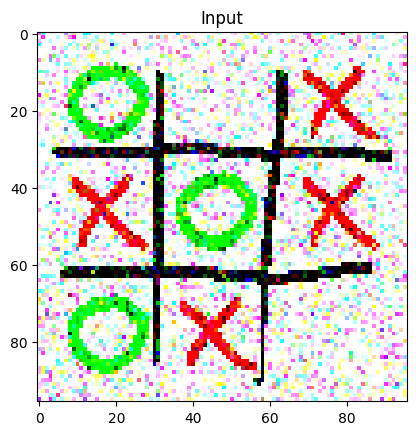

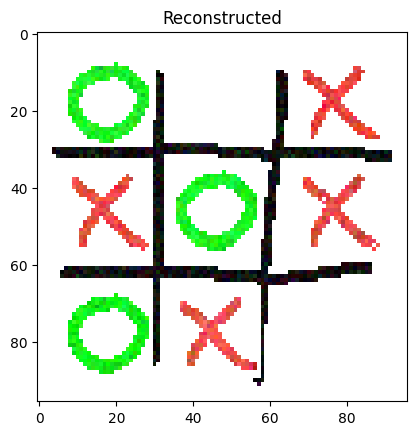

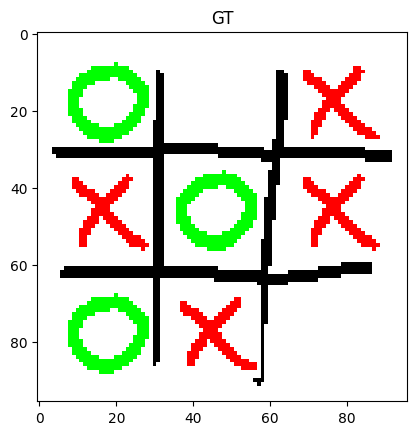

Evaluation Score is: 21.561
Mean Reconstruction Error is: 18.361
Mean Compressed Image Size is: 32
Codebook size is: 940032


In [ ]:
im_id = random.sample(list(range(50)), 1)[0]

input_image = val_images[im_id]
gt_image = val_gt[im_id]
im_compressed = compressor.compress(input_image)

im_recon = reconstructor.reconstruct(im_compressed)
show_image(input_image, 'Input')
show_image(im_recon, 'Reconstructed')
show_image(gt_image, 'GT')

recon_error = evaluation.get_reconstruction_error(im_recon, gt_image)
compressed_im_size = evaluation.get_size(im_compressed)
codebook_size = evaluation.get_size(compressor.get_codebook())
eval_score = evaluation.get_combined_score(recon_error, compressed_im_size, codebook_size)

print(f'Evaluation Score is: {eval_score:0.3f}')
print(f'Mean Reconstruction Error is: {recon_error:0.3f}')
print(f'Mean Compressed Image Size is: {compressed_im_size}')
print(f'Codebook size is: {codebook_size}')

Once your are happy with your implementation, you can test on the full validation set to obtain the evaluation score. **Important:** Ensure that you can execute the next cell without any errors to compute the evaluation score.

In [ ]:
import image_compressor

# Learn the compressor
compressor = image_compressor.ImageCompressor()
compressor.train(train_images)

# Compress all images

im_compressed = [compressor.compress(im) for im in val_images]

codebook = compressor.get_codebook()

eval_score, recon_error, compressed_im_size, codebook_size = evaluation.compute_evaluation_score(im_compressed, val_gt, codebook)

print(f'Evaluation Score is: {eval_score:0.3f}')
print(f'Mean Reconstruction Error is: {recon_error:0.3f}')
print(f'Mean Compressed Image Size is: {compressed_im_size}')
print(f'Codebook size is: {codebook_size}')

Evaluation Score is: 17.384
Mean Reconstruction Error is: 14.184
Mean Compressed Image Size is: 32.0
Codebook size is: 940032


## Generate the final submission on the test set

After finishing your implementation, you can run the next cell to generate the results, which will be stored in the submission directory on your Google Drive. This cell saves the compressed representation of each test image, the learnt codebook, as well as your implementation of the `image_compressor.py` to the submission directory. Download the submission folder (**without renaming**) as a zip, and upload it to the evaluation server (https://codalab.lisn.upsaclay.fr/competitions/7754) to obtain the scores on the test set.


In [ ]:
import image_compressor
import shutil

compressor = image_compressor.ImageCompressor()
compressor.train(train_images)

out_dir = f'{env_path}/submission'
os.makedirs(out_dir, exist_ok=True)
for im_id, im in enumerate(test_images):
    im_compressed = compressor.compress(im)
    np.save(f'{out_dir}/{im_id:03d}.npy', im_compressed)

codebook = compressor.get_codebook()
np.save(f'{out_dir}/codebook.npy', codebook)
shutil.copyfile(f'{env_path}/image_compressor.py', f'{out_dir}/image_compressor.py')

'/content/drive//MyDrive/iacv_exercises/ex1_compression/submission/image_compressor.py'